In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams["figure.figsize"] = (20,10)

In [2]:
df = pd.read_csv('/home/Documents/Bengaluru_House_Data.csv')
df.head()

FileNotFoundError: [Errno 2] File /home/Documents/Bengaluru_House_Data.csv does not exist: '/home/Documents/Bengaluru_House_Data.csv'

In [3]:
df.shape

(13320, 9)

In [4]:
df.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df0 = df.drop(['area_type','availability','balcony'],axis='columns')

In [6]:
# Data Cleaning

In [7]:
df0.isnull().sum()
# so dropping NA ros vaulue as they are very less in number 
df0 = df0.dropna()
df0.isnull().sum()

location      0
size          0
society       0
total_sqft    0
bath          0
price         0
dtype: int64

In [8]:
#exploring the size Feature
df0['size'].unique()
# As the data is not in the right format ,we will add a new column which would have the common format for all the enteries 

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '3 Bedroom', '1 RK',
       '1 BHK', '5 BHK', '11 BHK', '5 Bedroom', '9 BHK', '6 Bedroom',
       '2 Bedroom', '9 Bedroom', '6 BHK', '7 BHK', '10 Bedroom',
       '8 Bedroom', '18 Bedroom'], dtype=object)

In [9]:
df0['BHK'] = df0['size'].apply(lambda x: int(x.split(' ')[0]))
dfa = df0.drop(['size'],axis='columns')

In [10]:
dfa.total_sqft.unique()


array(['1056', '2600', '1521', ..., '1919', '2111', '4689'], dtype=object)

In [11]:
# There may be some vaules in total_sqft 
def is_float(x):
    try:
        float(x)
    except:
        return False 
    return True
dfa[~dfa['total_sqft'].apply(is_float)].head()
#dfa.shape

,location,society,total_sqft,bath,price,BHK
30,Yelahanka,LedorSa,2100 - 2850,4.0,186.000,4
122,Hebbal,SNontle,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,Vaarech,1042 - 1105,2.0,54.005,2
165,Sarjapur,Kinuerg,1145 - 1340,2.0,43.490,2
188,KR Puram,MCvarar,1015 - 1540,2.0,56.800,2


In [12]:
# To return the average of the area
def area_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None


In [13]:
#applying this function on the total_sqft
df3 = dfa.copy()
df3['total_sqft'] = df3['total_sqft'].apply(area_to_num)

In [14]:
#FEATURE ENGINEERING
#Creating a ne feature
df3['price_per_sqft'] = df3['price']*100000/df3['total_sqft']
df3.head()

,location,society,total_sqft,bath,price,BHK,price_per_sqft
0,Electronic City Phase II,Coomee,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,Theanmp,2600.0,5.0,120.00,4,4615.384615
3,Lingadheeranahalli,Soiewre,1521.0,3.0,95.00,3,6245.890861
5,Whitefield,DuenaTa,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,Jaades,2732.0,4.0,204.00,4,7467.057101


In [15]:
# As, we know that one Bedroom at least requires 300 square feet data 
# so , all the rows that have the quotient of df3.total_sqft/df3.BHK < 300 means they are outliners
# So, removing all those outliners.
df3[df3.total_sqft/df3.BHK<300].head()

,location,society,total_sqft,bath,price,BHK,price_per_sqft
349,Suragajakkanahalli,PrhyaK,11.0,3.0,74.0,3,672727.272727
480,RMV 2nd Stage,LiaveEn,1150.0,4.0,260.0,4,22608.695652
483,3rd Block Hrbr Layout,Bemesrm,1200.0,5.0,190.0,5,15833.333333
783,Mylasandra,VaitySe,900.0,7.0,76.0,6,8444.444444
1239,Electronic City,Itelaa,550.0,1.0,16.0,2,2909.090909


In [16]:
df4 = df3[~(df3.total_sqft/df3.BHK<300)]

In [17]:
# we may also other outliners like the ones with very high or low price_per_sqft
# we'll use describe() to get some basic statistics about the price_per_sqft
# From here we get the minimun and maximun rates and see if they are outliners
df4.price_per_sqft.describe()

count     7685.000000
mean      5908.540931
std       2753.085359
min        371.428571
25%       4300.000000
50%       5365.797546
75%       6748.808713
max      76530.612245
Name: price_per_sqft, dtype: float64

In [18]:
# So, here as you can see that both max and min are extremities
# we'll remove these extreme cases using standard deviation

def remove_outliners(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduce_df = subdf[(subdf.price_per_sqft > (m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduce_df],ignore_index=True)
    return df_out 
df5 = remove_outliners(df4)

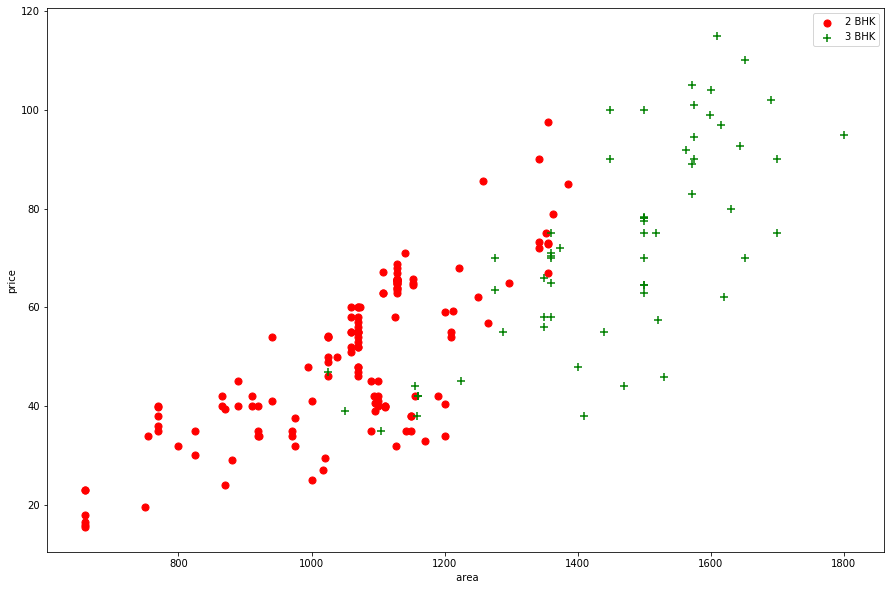

In [19]:
# compare prices of 2 and 3 BHK prices
def scatter_plot(dff,location):
    bhk2 = dff[(dff.location == location) & (dff.BHK == 2)]
    bhk3 = dff[(dff.location == location) & (dff.BHK == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='red',label='2 BHK',s = 50)
    plt.scatter(bhk3.total_sqft, bhk3.price, marker='+',color='green',label='3 BHK',s=50)
    plt.xlabel(" area")
    plt.ylabel("price")
    plt.legend()
scatter_plot(df5,'Electronic City')

In [20]:
def remove_bhk_outliners(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('BHK'):
            bhk_stats[bhk] = {
                 'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('BHK'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')

In [21]:
df6 = remove_bhk_outliners(df5)

In [22]:
# Checking for the outliners in the bathrooms 

In [23]:
df6 = df6[df6.bath<10]

Modelling

In [24]:
dummies = pd.get_dummies(df6.location)
dummies.head()
#dummies.#['Devarachikkanahalli']

,Devarabeesana Halli,Devarachikkanahalli,Electronic City,Rachenahalli,Thanisandra,1st Block Koramangala,1st Phase JP Nagar,2nd Phase JP Nagar,3rd Block Hrbr Layout,5th Phase JP Nagar,...,Vittasandra,Volagerekallahalli,Whitefield,Wilson Garden,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yemlur,Yeshwanthpur
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df7 = pd.concat([df6,dummies],axis='columns')
df7.head()

,location,society,total_sqft,bath,price,BHK,price_per_sqft,Devarabeesana Halli,Devarachikkanahalli,Electronic City,...,Vittasandra,Volagerekallahalli,Whitefield,Wilson Garden,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yemlur,Yeshwanthpur
0,Devarabeesana Halli,Sorisa,1672.0,3.0,150.0,3,8971.291866,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Devarabeesana Halli,Sorisa,1750.0,3.0,149.0,3,8514.285714,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Devarabeesana Halli,Sorisa,1750.0,3.0,150.0,3,8571.428571,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Devarachikkanahalli,Shireru,1425.0,2.0,65.0,3,4561.403509,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Devarachikkanahalli,Wiaysld,1705.0,3.0,75.0,3,4398.826979,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df8 = df7.drop(['location','society'],axis='columns')

In [27]:
X = df8.drop(['price'],axis= 'columns')
Y = df8.price

In [28]:
# geting our training and testing sets 
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size= 0.3,random_state = 10)

In [29]:
# Using the Linear Regression Modelling after doing the GridSearchCV
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
lr.score(x_test,y_test)

0.9625697284763661

In [30]:
def predicting_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1
    return lr.predict([x])[0]

In [31]:
#loc_index = np.where(X.columns==location)[0][0]
predicting_price('Rachenahalli', 10000,2,3 )

679.2256560208159

In [33]:
# expoting the pickle file 
import pickle 
with open ('house_price_prediction.pickle','wb') as f:
    pickle.dump(lr,f)

In [35]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [ ]:
# After this we will rite a python Flask server